# Data

Using device: cpu
Using device: cpu


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


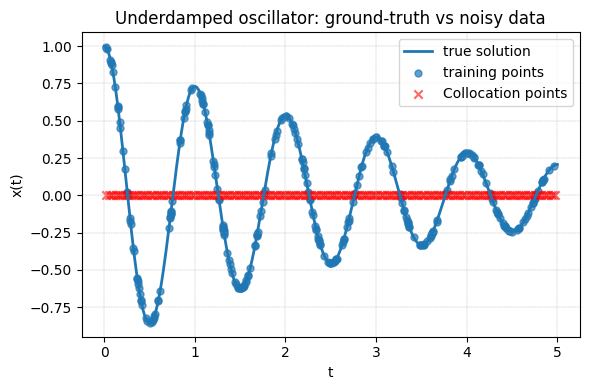

In [1]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from utils_tools.utils_tuning import save_plot

torch.set_num_threads(4)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_damposcillation import DampedOscillator1D  

ζ      = 0.05                       # damping ratio
ω      = 2 * math.pi * 1.0          # natural frequency (1 Hz)
ω_d    = ω * math.sqrt(1 - ζ**2)    # damped natural frequency
u0, v0 = 1.0, 0.0                   # initial displacement & velocity

forcing_func  = lambda t: 0.0 * t   # zero external force

true_solution = lambda t: (
    np.exp(-ζ * ω * t) *
    (u0 * np.cos(ω_d * t) + (v0 + ζ * ω * u0) / ω_d * np.sin(ω_d * t))
)

domain = (0.0, 5.0)                 # simulate 10 s

pde = DampedOscillator1D(
    zeta=ζ, omega=ω, forcing_func=forcing_func,
    init_cond=(u0, v0), domain=domain, true_solution=true_solution
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Training / calibration / test data
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 200

data_noise = 0.0
(X_train, Y_train)         = pde.data_generation(300, data_noise)
(X_test, Y_test)           = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(x_colloc_num, data_noise)


# Collocation points in (0,5)
x_collocation = torch.linspace(*domain, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > domain[0]) & (x_collocation < domain[1])].view(-1, 1)

# Dense grid for nice plotting
grid_test = torch.linspace(*domain, 800).unsqueeze(1)

# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [2]:
def add_heteroscedastic_noise_center_peak(X, Y_clean, noise_level=0.2, x0=0.0, x1=5.0, power=2):
    """
    Add heteroscedastic noise that is largest at the center of the domain.

    Parameters
    ----------
    X : torch.Tensor of shape (N, 1)
    Y_clean : torch.Tensor of shape (N, 1)
    noise_level : float, base noise scale
    x0, x1 : float, domain boundaries
    power : int, controls how sharply noise falls off away from center

    Returns
    -------
    Y_noisy : torch.Tensor of shape (N, 1)
    """
    midpoint = 0.5 * (x0 + x1)
    dist = torch.abs(X - midpoint)
    max_dist = (x1 - x0) / 2.0
    scale = 1.0 - (dist / max_dist) ** power   # max at center, min at edges

    noise = noise_level * scale * torch.randn_like(Y_clean)
    return Y_clean + noise


In [3]:
# Domain info
x0, x1 = domain

# True outputs without noise
Y_train_clean = Y_train.clone()
Y_test_clean  = Y_test.clone()
Y_cal_clean   = Y_calibration.clone()

# Add heteroscedastic noise
Y_train        = add_heteroscedastic_noise_center_peak(X_train, Y_train_clean, noise_level=0.1, x0=x0, x1=x1)
Y_test         = add_heteroscedastic_noise_center_peak(X_test,  Y_test_clean,  noise_level=0.1, x0=x0, x1=x1)
Y_calibration  = add_heteroscedastic_noise_center_peak(X_calibration, Y_cal_clean, noise_level=0.1, x0=x0, x1=x1)


In [4]:
# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
save_plot(
    plot_truth_and_samples_1D,
    save_dir="Adaptive_scaled_CP",
    prefix="heteroscedasticity_data"
)(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

<Figure size 640x480 with 0 Axes>

# Training Base Model

In [5]:
# UQ Model
from utils_uqmd.utils_uq_distance import DistanceUQPINN

model_args = {
    "pde_class":pde,
    "input_dim":1,
    "hidden_dims":[16, 32,64,128, 128, 64,32, 16],
    "output_dim":1,
}

uqmodel = DistanceUQPINN(**model_args)
alpha = 0.05
raw_heuristic = "feature"

# Fit the data
fit_args = dict(coloc_pt_num=200, X_train=X_train, Y_train=Y_train)
fit_kwargs_grid = dict(
    epochs=50000,
    λ_pde= 2.0, λ_ic=10.0, λ_data=3.0,
    lr=1e-3, stop_schedule=40000
)
print(f"\n[🟠] Training...")
baseline_loss_dict = uqmodel.fit(**fit_args, **fit_kwargs_grid)

# Model Inferencing
baseline_pred_kwargs = dict(n_samples=200, heuristic_u=raw_heuristic)
print(f"\n[🟠] Base Model Inferencing...")
cp_uncal_predset = uqmodel.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


[🟠] Training...
ep     1 | L=1.87e+02 | lr=1.0e-03
ep   500 | L=1.01e+01 | lr=1.0e-03
ep  1000 | L=9.88e+00 | lr=1.0e-03
ep  1500 | L=8.14e+00 | lr=1.0e-03
ep  2000 | L=7.58e+00 | lr=1.0e-03
ep  2500 | L=8.16e+00 | lr=1.0e-03
ep  3000 | L=7.58e+00 | lr=1.0e-03
ep  3500 | L=8.87e+00 | lr=1.0e-03
ep  4000 | L=8.47e+00 | lr=1.0e-03
ep  4500 | L=5.73e+00 | lr=1.0e-03
ep  5000 | L=4.38e+00 | lr=1.0e-03
ep  5500 | L=4.15e+00 | lr=7.0e-04
ep  6000 | L=2.42e+00 | lr=7.0e-04
ep  6500 | L=2.03e+00 | lr=7.0e-04
ep  7000 | L=2.05e+00 | lr=7.0e-04
ep  7500 | L=2.25e+00 | lr=7.0e-04
ep  8000 | L=2.16e+00 | lr=7.0e-04
ep  8500 | L=1.80e+00 | lr=7.0e-04
ep  9000 | L=1.58e+00 | lr=7.0e-04
ep  9500 | L=1.25e+00 | lr=7.0e-04
ep 10000 | L=3.01e+00 | lr=7.0e-04
ep 10500 | L=9.01e-01 | lr=4.9e-04
ep 11000 | L=7.60e-01 | lr=4.9e-04
ep 11500 | L=1.09e+00 | lr=4.9e-04
ep 12000 | L=9.13e-01 | lr=4.9e-04
ep 12500 | L=9.18e-01 | lr=4.9e-04
ep 13000 | L=5.45e-01 | lr=4.9e-04
ep 13500 | L=4.88e-01 | lr=4.9e-04
ep 

# Adaptive Scaled CP

In [6]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP, adaptive_cp_test_uncertainties_grid
adap_cp = AdaptiveCP(uqmodel, alpha=alpha)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, k=20,
    heuristic_u=raw_heuristic
)


[🟠] Training Adaptive CP Model


In [7]:
from utils_tools.utils_result_viz import plot_1d_intervals_comparison
save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=adp_cp_cal_predset,
    uncal_interval_label="Naive UQ Band",
    cal_interval_label="Adaptive Scaled CP Band",
    true_solution=pde.true_solution,            # pass the function
    t_train=X_train,
    y_train=Y_train,
    title="0.05-Alpha Level Adaptive Scaled Conformal Calibrated Prediction"
)

<Figure size 640x480 with 0 Axes>

# Normal Scaled CP

In [8]:
# Normal CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":raw_heuristic,  # Change this based on cp
        "k":20
}
from utils_uqmd.utils_uq_cp import CP
cp_model = CP(uqmodel)
cp_cal_predset = cp_model.predict(
            alpha=alpha, X_test=grid_test,
            **cp_pred_kwargs
        )

In [9]:
save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="cp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=cp_cal_predset,
    true_solution=pde.true_solution, 
    uncal_interval_label="Naive UQ Band",
    cal_interval_label="Scaled CP Band",
    t_train=X_train,
    y_train=Y_train,
    title="0.05-Alpha Level Scaled Conformal Calibrated Prediction"
)

<Figure size 640x480 with 0 Axes>

# Visual Comparison: Scaled CP v.s. Adaptive Scaled CP

In [10]:
save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_vs_cp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_cal_predset,
    cp_intervals=adp_cp_cal_predset,
    true_solution=pde.true_solution,            
    uncal_interval_label="Scaled CP Band",
    cal_interval_label="Adaptive Scaled CP Band",
    t_train=X_train,
    y_train=Y_train,
    title="0.05-Alpha Level Scaled CP v.s. Adaptive Scaled CP Prediction"
)

<Figure size 640x480 with 0 Axes>

# Test model's coverage

In [11]:
# CP Coverage comparison
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(20)


cp_testing_args = {
    "uqmodel": cp_model,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
adapcp_testing_args = {
    "base_md": uqmodel,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
cp_df = cp_test_uncertainties(**cp_testing_args)
adap_df = adaptive_cp_test_uncertainties_grid(**adapcp_testing_args)

Adaptive-CP grid:  16%|█▌        | 3/19 [00:00<00:00, 25.95it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


Adaptive-CP grid:  47%|████▋     | 9/19 [00:00<00:00, 27.16it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


Adaptive-CP grid:  79%|███████▉  | 15/19 [00:00<00:00, 27.52it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


Adaptive-CP grid: 100%|██████████| 19/19 [00:00<00:00, 27.28it/s]


[🟠] Training Adaptive CP Model


In [12]:
from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
save_plot(
    plot_dual_expected_vs_empirical,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_cp_coverage_plot"
)(cp_df, adap_df, title1="Scaled CP", title2="Adaptive Scaled CP", 
  main_title="Coverage Plot of Adaptive Conformal Prediction & Conformal Prediction Across Alpha Levels")

<Figure size 640x480 with 0 Axes>

In [13]:
from utils_tools.utils_result_viz import plot_metrics_table

df1=cp_df
df2=adap_df
df1_name="CP" 
df2_name="Adaptive CP"
save_plot(
    plot_metrics_table,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_vs_cp_table"
)(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics")

<Figure size 640x480 with 0 Axes>